In [29]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u

import random

def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
N_points = 1000  # Number of collocation points (x, t) in the domain
epochs = 3000  # Number of training epochs

T_final = 0.5 # Example final time
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.beta(3, 1, size=N_points) * T_final
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)


2025-12-13 17:47:39.771912: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-13 17:47:39.771949: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-13 17:47:39.771959: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-13 17:47:39.771980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-13 17:47:39.771998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
#WIDTH TEST
widths = [20, 50, 100, 150, 200, 250]
seeds = [0, 1, 2, 3, 4]  

epochs = 3000
results_width_seed = []

for w in widths:
    print(f"\n=== Width: {w} ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)

        # Build model for this width + seed
        model = create_network_model(layers=[w], activation='tanh')
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        train_step = make_train_step(model, optimizer, compute_loss)

        # Train
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"    Epoch {epoch}: loss = {loss.numpy():.3e}")

        mse = compute_MSE(model, T_final=T_final)
        results_width_seed.append((w, seed, float(loss.numpy()), mse))

# Turn into DataFrame
df_ws = pd.DataFrame(results_width_seed,
                     columns=["Width", "Seed", "Residual loss", "MSE"])

# Aggregate over seeds: mean and std
df_width_summary = (
    df_ws
    .groupby("Width")
    .agg(mean_mse=("MSE", "mean"),
         std_mse=("MSE", "std"),
         mean_residual=("Residual loss", "mean"))
    .reset_index()
)

print(df_width_summary)



=== Width: 20 ===
  Seed 0


2025-12-13 17:47:40.202987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


    Epoch 0: loss = 2.211e+01
    Epoch 500: loss = 8.930e-01
    Epoch 1000: loss = 1.495e-01
    Epoch 1500: loss = 5.268e-02
    Epoch 2000: loss = 2.628e-02
    Epoch 2500: loss = 1.324e-02
  Seed 1
    Epoch 0: loss = 1.935e+01
    Epoch 500: loss = 6.153e-01
    Epoch 1000: loss = 8.031e-02
    Epoch 1500: loss = 2.842e-02
    Epoch 2000: loss = 1.617e-02
    Epoch 2500: loss = 1.109e-02
  Seed 2
    Epoch 0: loss = 2.190e+01
    Epoch 500: loss = 9.441e-01
    Epoch 1000: loss = 1.563e-01
    Epoch 1500: loss = 4.824e-02
    Epoch 2000: loss = 2.466e-02
    Epoch 2500: loss = 1.266e-02
  Seed 3
    Epoch 0: loss = 2.062e+01
    Epoch 500: loss = 8.295e-01
    Epoch 1000: loss = 1.404e-01
    Epoch 1500: loss = 4.603e-02
    Epoch 2000: loss = 2.348e-02
    Epoch 2500: loss = 1.316e-02
  Seed 4
    Epoch 0: loss = 2.078e+01
    Epoch 500: loss = 9.391e-01
    Epoch 1000: loss = 1.783e-01
    Epoch 1500: loss = 5.312e-02
    Epoch 2000: loss = 2.468e-02
    Epoch 2500: loss = 1.11

In [6]:
depth_architectures = [
    [150],
    [150, 150],
    [150, 150, 150],
    [150, 150, 150, 150],
] 

results_layers = []

for layers in depth_architectures:
    print(f"\n=== Depth experiment: layers={layers}, tanh ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)
    # Build new model
        model = create_network_model(layers=layers)
    
    # IMPORTANT: new optimizer for each model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    # Reset traced graph: DON'T reuse old tf.function trace
        train_step = make_train_step(model, optimizer, compute_loss)

    # Train
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

        mse = compute_MSE(model, T_final=T_final)
        results_layers.append((str(layers), float(loss.numpy()), mse))
    #print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")

df_layers = pd.DataFrame(results_layers, columns=["Architecture", "Residual loss", "MSE"])

# Aggregate over seeds: mean and std
df_depth_summary = (
    df_layers
    .groupby("Architecture")
    .agg(mean_mse=("MSE", "mean"),
         std_mse=("MSE", "std"),
         mean_residual=("Residual loss", "mean"))
    .reset_index()
)

print(df_depth_summary)


=== Depth experiment: layers=[150], tanh ===
  Seed 0
  Epoch 0: loss = 2.027e+01
  Epoch 500: loss = 2.229e-01
  Epoch 1000: loss = 1.860e-02
  Epoch 1500: loss = 8.765e-03
  Epoch 2000: loss = 5.387e-03
  Epoch 2500: loss = 3.430e-03
  Seed 1
  Epoch 0: loss = 1.984e+01
  Epoch 500: loss = 6.750e-01
  Epoch 1000: loss = 3.685e-02
  Epoch 1500: loss = 2.204e-02
  Epoch 2000: loss = 1.206e-02
  Epoch 2500: loss = 8.220e-03
  Seed 2
  Epoch 0: loss = 2.139e+01
  Epoch 500: loss = 2.982e-01
  Epoch 1000: loss = 4.360e-02
  Epoch 1500: loss = 1.464e-02
  Epoch 2000: loss = 7.412e-03
  Epoch 2500: loss = 5.071e-03
  Seed 3
  Epoch 0: loss = 2.120e+01
  Epoch 500: loss = 2.838e-01
  Epoch 1000: loss = 2.421e-02
  Epoch 1500: loss = 1.426e-02
  Epoch 2000: loss = 1.110e-02
  Epoch 2500: loss = 1.238e-02
  Seed 4
  Epoch 0: loss = 2.051e+01
  Epoch 500: loss = 3.475e-01
  Epoch 1000: loss = 1.868e-02
  Epoch 1500: loss = 1.040e-02
  Epoch 2000: loss = 6.212e-03
  Epoch 2500: loss = 9.347e-03

In [7]:
#ACTIVATION TEST

activations = ['tanh', 'sigmoid', 'relu', 'swish']

results_activations = []
epochs = 3000

for act in activations:
    print(f"\n=== Activation experiment: {act}, layers=[150] ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)

    # 1. Create model with the activation
        model = create_network_model(layers=[150], activation=act)

    # 2. New optimizer per model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # 3. Create a NEW train_step bound to this model & optimizer
        train_step = make_train_step(model, optimizer, compute_loss)

    # 4. Training loop
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    # 5. Compute accuracy
        mse = compute_MSE(model, T_final=T_final)

        results_activations.append((act, float(loss.numpy()), mse))

    #print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")

df_act = pd.DataFrame(results_activations, columns=["Activation", "Residual loss", "MSE"])
print(df_act)



=== Activation experiment: tanh, layers=[150] ===
  Seed 0
  Epoch 0: loss = 2.027e+01
  Epoch 500: loss = 2.229e-01
  Epoch 1000: loss = 1.860e-02
  Epoch 1500: loss = 8.765e-03
  Epoch 2000: loss = 5.387e-03
  Epoch 2500: loss = 3.430e-03
  Seed 1
  Epoch 0: loss = 1.984e+01
  Epoch 500: loss = 6.750e-01
  Epoch 1000: loss = 3.685e-02
  Epoch 1500: loss = 2.204e-02
  Epoch 2000: loss = 1.206e-02
  Epoch 2500: loss = 8.220e-03
  Seed 2
  Epoch 0: loss = 2.139e+01
  Epoch 500: loss = 2.982e-01
  Epoch 1000: loss = 4.360e-02
  Epoch 1500: loss = 1.464e-02
  Epoch 2000: loss = 7.412e-03
  Epoch 2500: loss = 5.071e-03
  Seed 3
  Epoch 0: loss = 2.120e+01
  Epoch 500: loss = 2.838e-01
  Epoch 1000: loss = 2.421e-02
  Epoch 1500: loss = 1.426e-02
  Epoch 2000: loss = 1.110e-02
  Epoch 2500: loss = 1.238e-02
  Seed 4
  Epoch 0: loss = 2.051e+01
  Epoch 500: loss = 3.475e-01
  Epoch 1000: loss = 1.868e-02
  Epoch 1500: loss = 1.040e-02
  Epoch 2000: loss = 6.212e-03
  Epoch 2500: loss = 9.34

In [8]:
eta = [0.0001, 0.001, 0.01, 0.1, 1.0]
epochs = 3000

results_eta = []

for learning_rate in eta:
    print(f"\n=== Learning rate experiment: eta={learning_rate}, layers=[150], tanh ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)
    # 1. Create model
        model = create_network_model(layers=[150], activation='tanh')

    # 2. New optimizer per model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # 3. Create a NEW train_step bound to this model & optimizer
        train_step = make_train_step(model, optimizer, compute_loss)

    # 4. Training loop
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    # 5. Compute accuracy
        mse = compute_MSE(model, T_final=T_final)

        results_eta.append((learning_rate, float(loss.numpy()), mse))

    #print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")
    
df_eta = pd.DataFrame(results_eta, columns=["Learning rate", "Residual loss", "MSE"])
df_eta_summary = (
    df_eta.groupby("Learning rate")
          .agg(mean_mse=("MSE", "mean"),
               std_mse=("MSE", "std"),
               mean_residual=("Residual loss", "mean"))
          .reset_index()
)

print(df_eta_summary)


=== Learning rate experiment: eta=0.0001, layers=[150], tanh ===
  Seed 0
  Epoch 0: loss = 2.027e+01
  Epoch 500: loss = 1.274e+01
  Epoch 1000: loss = 1.009e+01
  Epoch 1500: loss = 9.268e+00
  Epoch 2000: loss = 8.671e+00
  Epoch 2500: loss = 7.997e+00
  Seed 1
  Epoch 0: loss = 1.984e+01
  Epoch 500: loss = 1.252e+01
  Epoch 1000: loss = 1.011e+01
  Epoch 1500: loss = 9.251e+00
  Epoch 2000: loss = 8.649e+00
  Epoch 2500: loss = 7.978e+00
  Seed 2
  Epoch 0: loss = 2.139e+01
  Epoch 500: loss = 1.335e+01
  Epoch 1000: loss = 1.011e+01
  Epoch 1500: loss = 9.218e+00
  Epoch 2000: loss = 8.664e+00
  Epoch 2500: loss = 8.071e+00
  Seed 3
  Epoch 0: loss = 2.120e+01
  Epoch 500: loss = 1.318e+01
  Epoch 1000: loss = 1.013e+01
  Epoch 1500: loss = 9.331e+00
  Epoch 2000: loss = 8.779e+00
  Epoch 2500: loss = 8.175e+00
  Seed 4
  Epoch 0: loss = 2.051e+01
  Epoch 500: loss = 1.274e+01
  Epoch 1000: loss = 1.004e+01
  Epoch 1500: loss = 9.183e+00
  Epoch 2000: loss = 8.587e+00
  Epoch 25

In [9]:
# OPTIMIZER TEST


best_layers = [150]   
best_activation = 'tanh'  
best_lr = 0.01             



results_optim = []

optimizers_to_test = ["Adam", "RMSProp"]

for opt_name in optimizers_to_test:
    print(f"\n=== Optimizer: {opt_name} ===")

    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)

        # Build model
        model = create_network_model(layers=best_layers,
                                     activation=best_activation)

        # IMPORTANT: new optimizer for each model (FIX)
        if opt_name == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
        elif opt_name == "RMSProp":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)

        # Build train step with fresh model + optimizer
        train_step = make_train_step(model, optimizer, compute_loss)

        # Train
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

        # Evaluate
        mse = compute_MSE(model, T_final=T_final)
        results_optim.append((opt_name, float(loss.numpy()), mse))
        
df_optim = pd.DataFrame(results_optim, columns=["Optimizer", "Residual loss", "MSE"])
print(df_optim)


=== Optimizer: Adam ===
  Seed 0
  Epoch 0: loss = 2.027e+01
  Epoch 500: loss = 2.229e-01
  Epoch 1000: loss = 1.860e-02
  Epoch 1500: loss = 8.765e-03
  Epoch 2000: loss = 5.387e-03
  Epoch 2500: loss = 3.430e-03
  Seed 1
  Epoch 0: loss = 1.984e+01
  Epoch 500: loss = 6.750e-01
  Epoch 1000: loss = 3.685e-02
  Epoch 1500: loss = 2.204e-02
  Epoch 2000: loss = 1.206e-02
  Epoch 2500: loss = 8.220e-03
  Seed 2
  Epoch 0: loss = 2.139e+01
  Epoch 500: loss = 2.982e-01
  Epoch 1000: loss = 4.360e-02
  Epoch 1500: loss = 1.464e-02
  Epoch 2000: loss = 7.412e-03
  Epoch 2500: loss = 5.071e-03
  Seed 3
  Epoch 0: loss = 2.120e+01
  Epoch 500: loss = 2.838e-01
  Epoch 1000: loss = 2.421e-02
  Epoch 1500: loss = 1.426e-02
  Epoch 2000: loss = 1.110e-02
  Epoch 2500: loss = 1.238e-02
  Seed 4
  Epoch 0: loss = 2.051e+01
  Epoch 500: loss = 3.475e-01
  Epoch 1000: loss = 1.868e-02
  Epoch 1500: loss = 1.040e-02
  Epoch 2000: loss = 6.212e-03
  Epoch 2500: loss = 9.347e-03

=== Optimizer: RMSP

In [ ]:
N_points_list = [500, 1000, 2000, 5000, 10000]  # choose whatever range you want

results_npoints = []

epochs = 3000
best_layers = [150]
best_activation = 'tanh'
best_learning_rate = 0.01
T_final = 0.5

for N_points in N_points_list:
    print(f"\n=== N_points = {N_points} ===")

    # Fix the seed so training is fair
    set_seed(42)

    # Build new model
    model = create_network_model(
        layers=best_layers,
        activation=best_activation
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
    train_step = make_train_step(model, optimizer, compute_loss)

    # Sample training points
    x_samples = np.random.uniform(0.0, 1.0, N_points)
    t_samples = np.random.beta(3, 1, size=N_points) * T_final
    X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

    # Train model
    for epoch in range(epochs):
        loss = train_step(X_train)
        if epoch % 500 == 0:
            print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    # Evaluate
    mse = compute_MSE(model, T_final=T_final)
    print(f"Final residual loss: {loss.numpy():.3e}")
    print(f"MSE vs analytical:  {mse:.3e}")

    # Save result
    results_npoints.append((N_points, float(loss.numpy()), mse))

# Make DataFrame
df_npoints = pd.DataFrame(results_npoints,
                          columns=["N_points", "Residual loss", "MSE"])

print(df_npoints)



=== N_points = 500 ===
  Epoch 0: loss = 2.037e+01
  Epoch 500: loss = 3.576e-01
  Epoch 1000: loss = 1.715e-02
  Epoch 1500: loss = 8.347e-03
  Epoch 2000: loss = 4.431e-03
  Epoch 2500: loss = 2.524e-03
Final residual loss: 1.824e-03
MSE vs analytical:  5.489e-07

=== N_points = 1000 ===
  Epoch 0: loss = 2.073e+01
  Epoch 500: loss = 2.747e-01
  Epoch 1000: loss = 1.735e-02
  Epoch 1500: loss = 8.271e-03
  Epoch 2000: loss = 6.672e-03
  Epoch 2500: loss = 2.049e-02
Final residual loss: 3.033e-03
MSE vs analytical:  6.003e-07

=== N_points = 2000 ===
  Epoch 0: loss = 2.081e+01
  Epoch 500: loss = 3.245e-01
  Epoch 1000: loss = 1.789e-02
  Epoch 1500: loss = 1.031e-02
  Epoch 2000: loss = 7.340e-03
  Epoch 2500: loss = 3.690e-03
Final residual loss: 2.309e-03
MSE vs analytical:  3.059e-07

=== N_points = 5000 ===
  Epoch 0: loss = 2.131e+01
  Epoch 500: loss = 3.526e-01
  Epoch 1000: loss = 1.911e-02
  Epoch 1500: loss = 1.692e-02
  Epoch 2000: loss = 8.475e-03
  Epoch 2500: loss = 

In [ ]:
T_finals = [0.1, 0.3, 0.5, 1.0]

for T_final in T_finals:
    print(f"\n=== T_final = {T_final} ===")

    # sample training points in [0, T_final]
    x_samples = np.random.uniform(0.0, 1.0, N_points)
    t_samples = np.random.beta(3, 1, size=N_points) * T_final
    X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

    model = create_network_model(layers=[150], activation="tanh")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    train_step = make_train_step(model, optimizer, compute_loss)

    for epoch in range(epochs):
        loss = train_step(X_train)

    mse = compute_MSE(model, T_final=T_final)
    print(f"Residual loss: {loss.numpy():.3e}, MSE: {mse:.3e}")



=== T_final = 0.1 ===
Residual loss: 2.586e-03, MSE: 2.021e-07

=== T_final = 0.3 ===
Residual loss: 1.561e-03, MSE: 1.596e-07

=== T_final = 0.5 ===
Residual loss: 3.791e-03, MSE: 4.324e-07

=== T_final = 1.0 ===
Residual loss: 6.119e-03, MSE: 3.767e-06


PLOTS

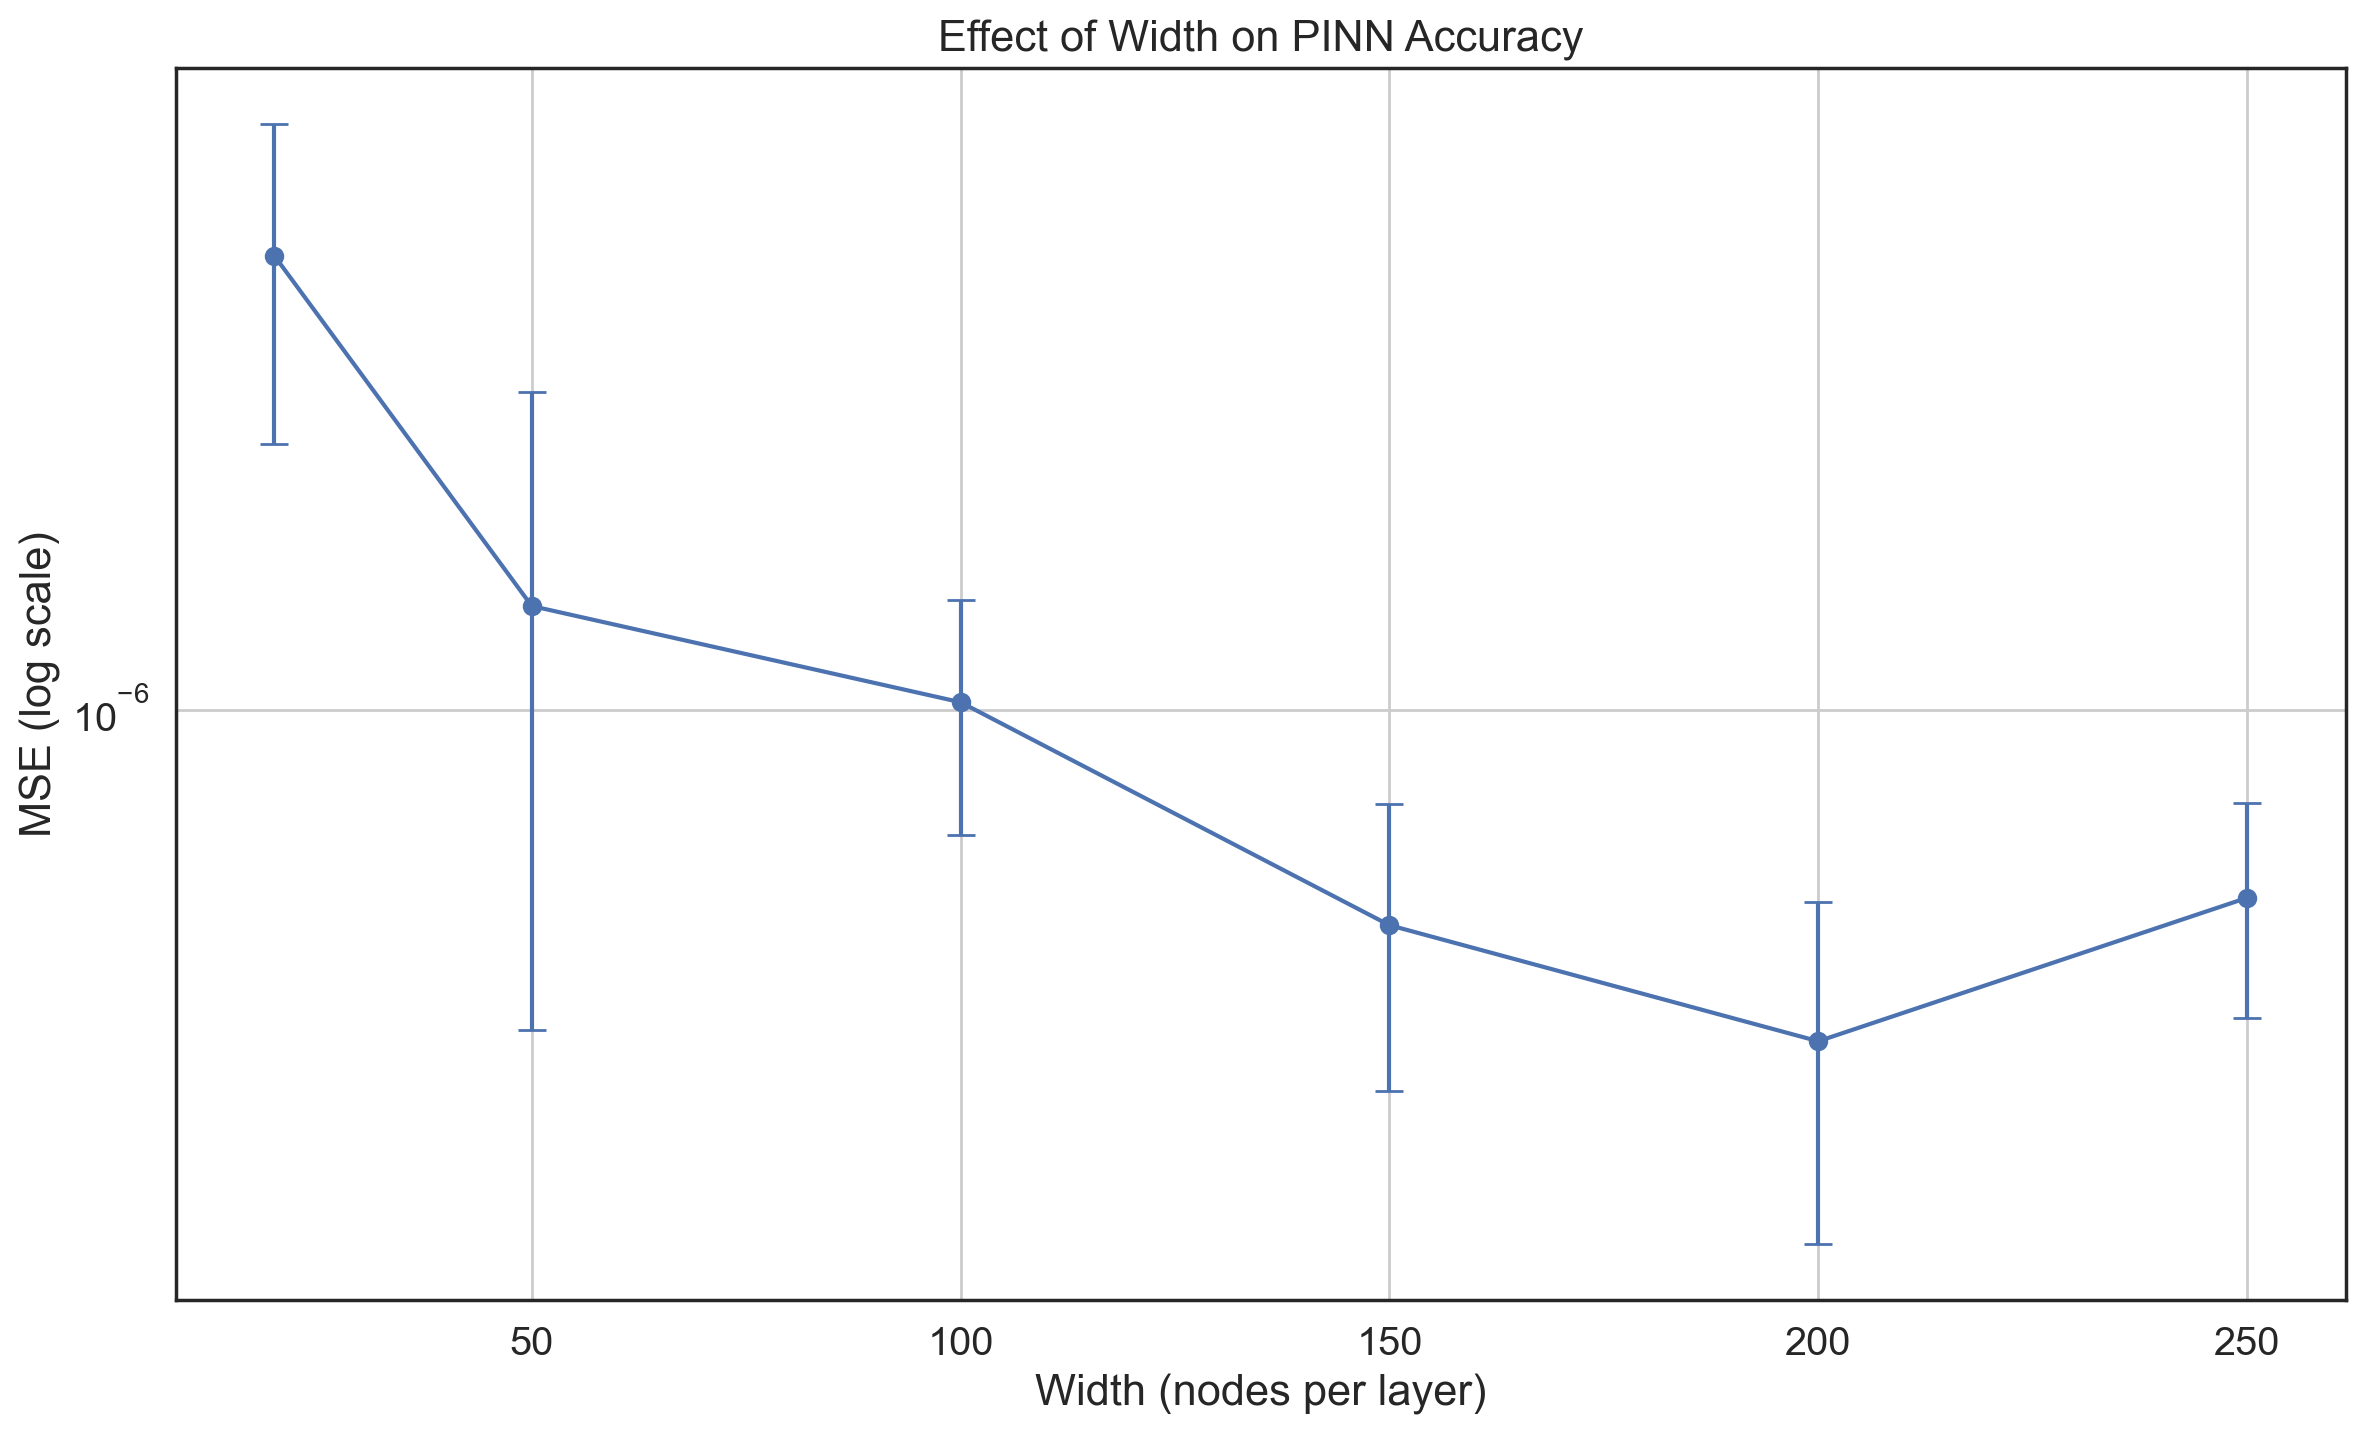

In [30]:
plt.errorbar(df_width_summary['Width'], df_width_summary['mean_mse'], 
             yerr=df_width_summary['std_mse'], fmt='o-', capsize=5)
plt.yscale('log')
plt.xlabel("Width (nodes per layer)")
plt.ylabel("MSE (log scale)")
plt.title("Effect of Width on PINN Accuracy")
plt.grid(True)
plt.show()


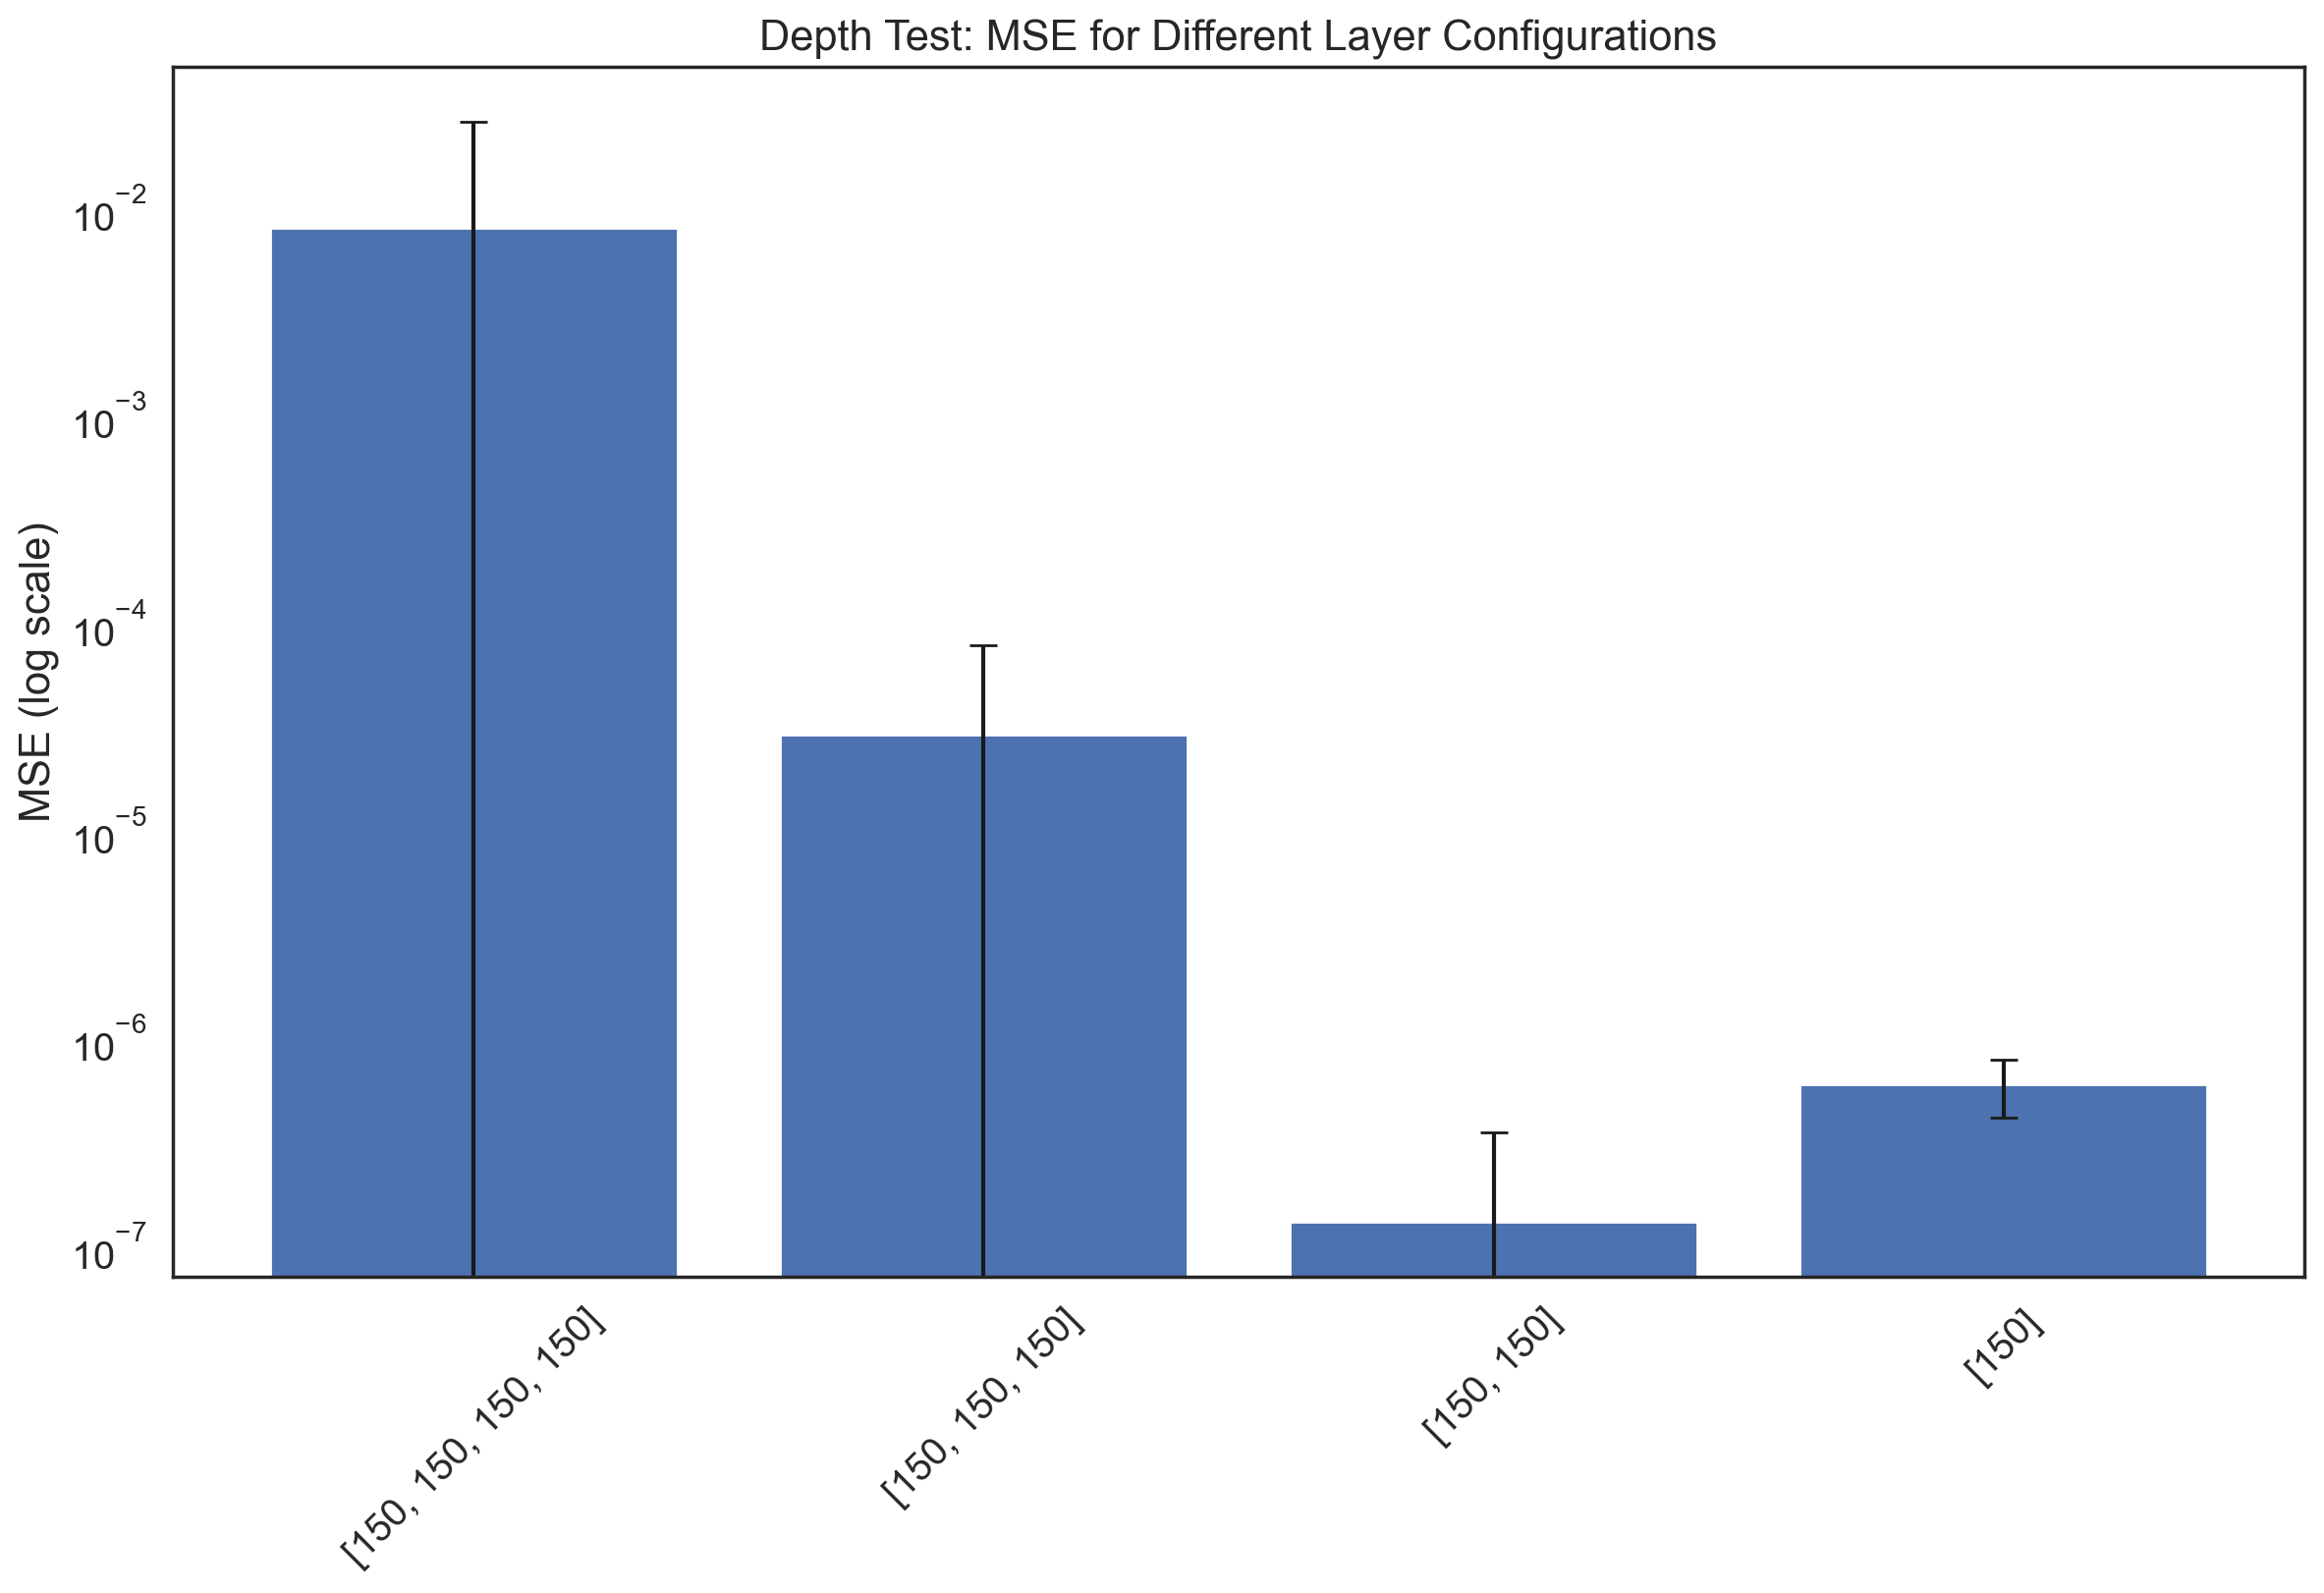

In [31]:
plt.bar(range(len(df_depth_summary)), df_depth_summary['mean_mse'], 
        yerr=df_depth_summary['std_mse'], capsize=5)
plt.xticks(range(len(df_depth_summary)), df_depth_summary['Architecture'], rotation=45)
plt.yscale('log')
plt.title("Depth Test: MSE for Different Layer Configurations")
plt.ylabel("MSE (log scale)")
plt.show()


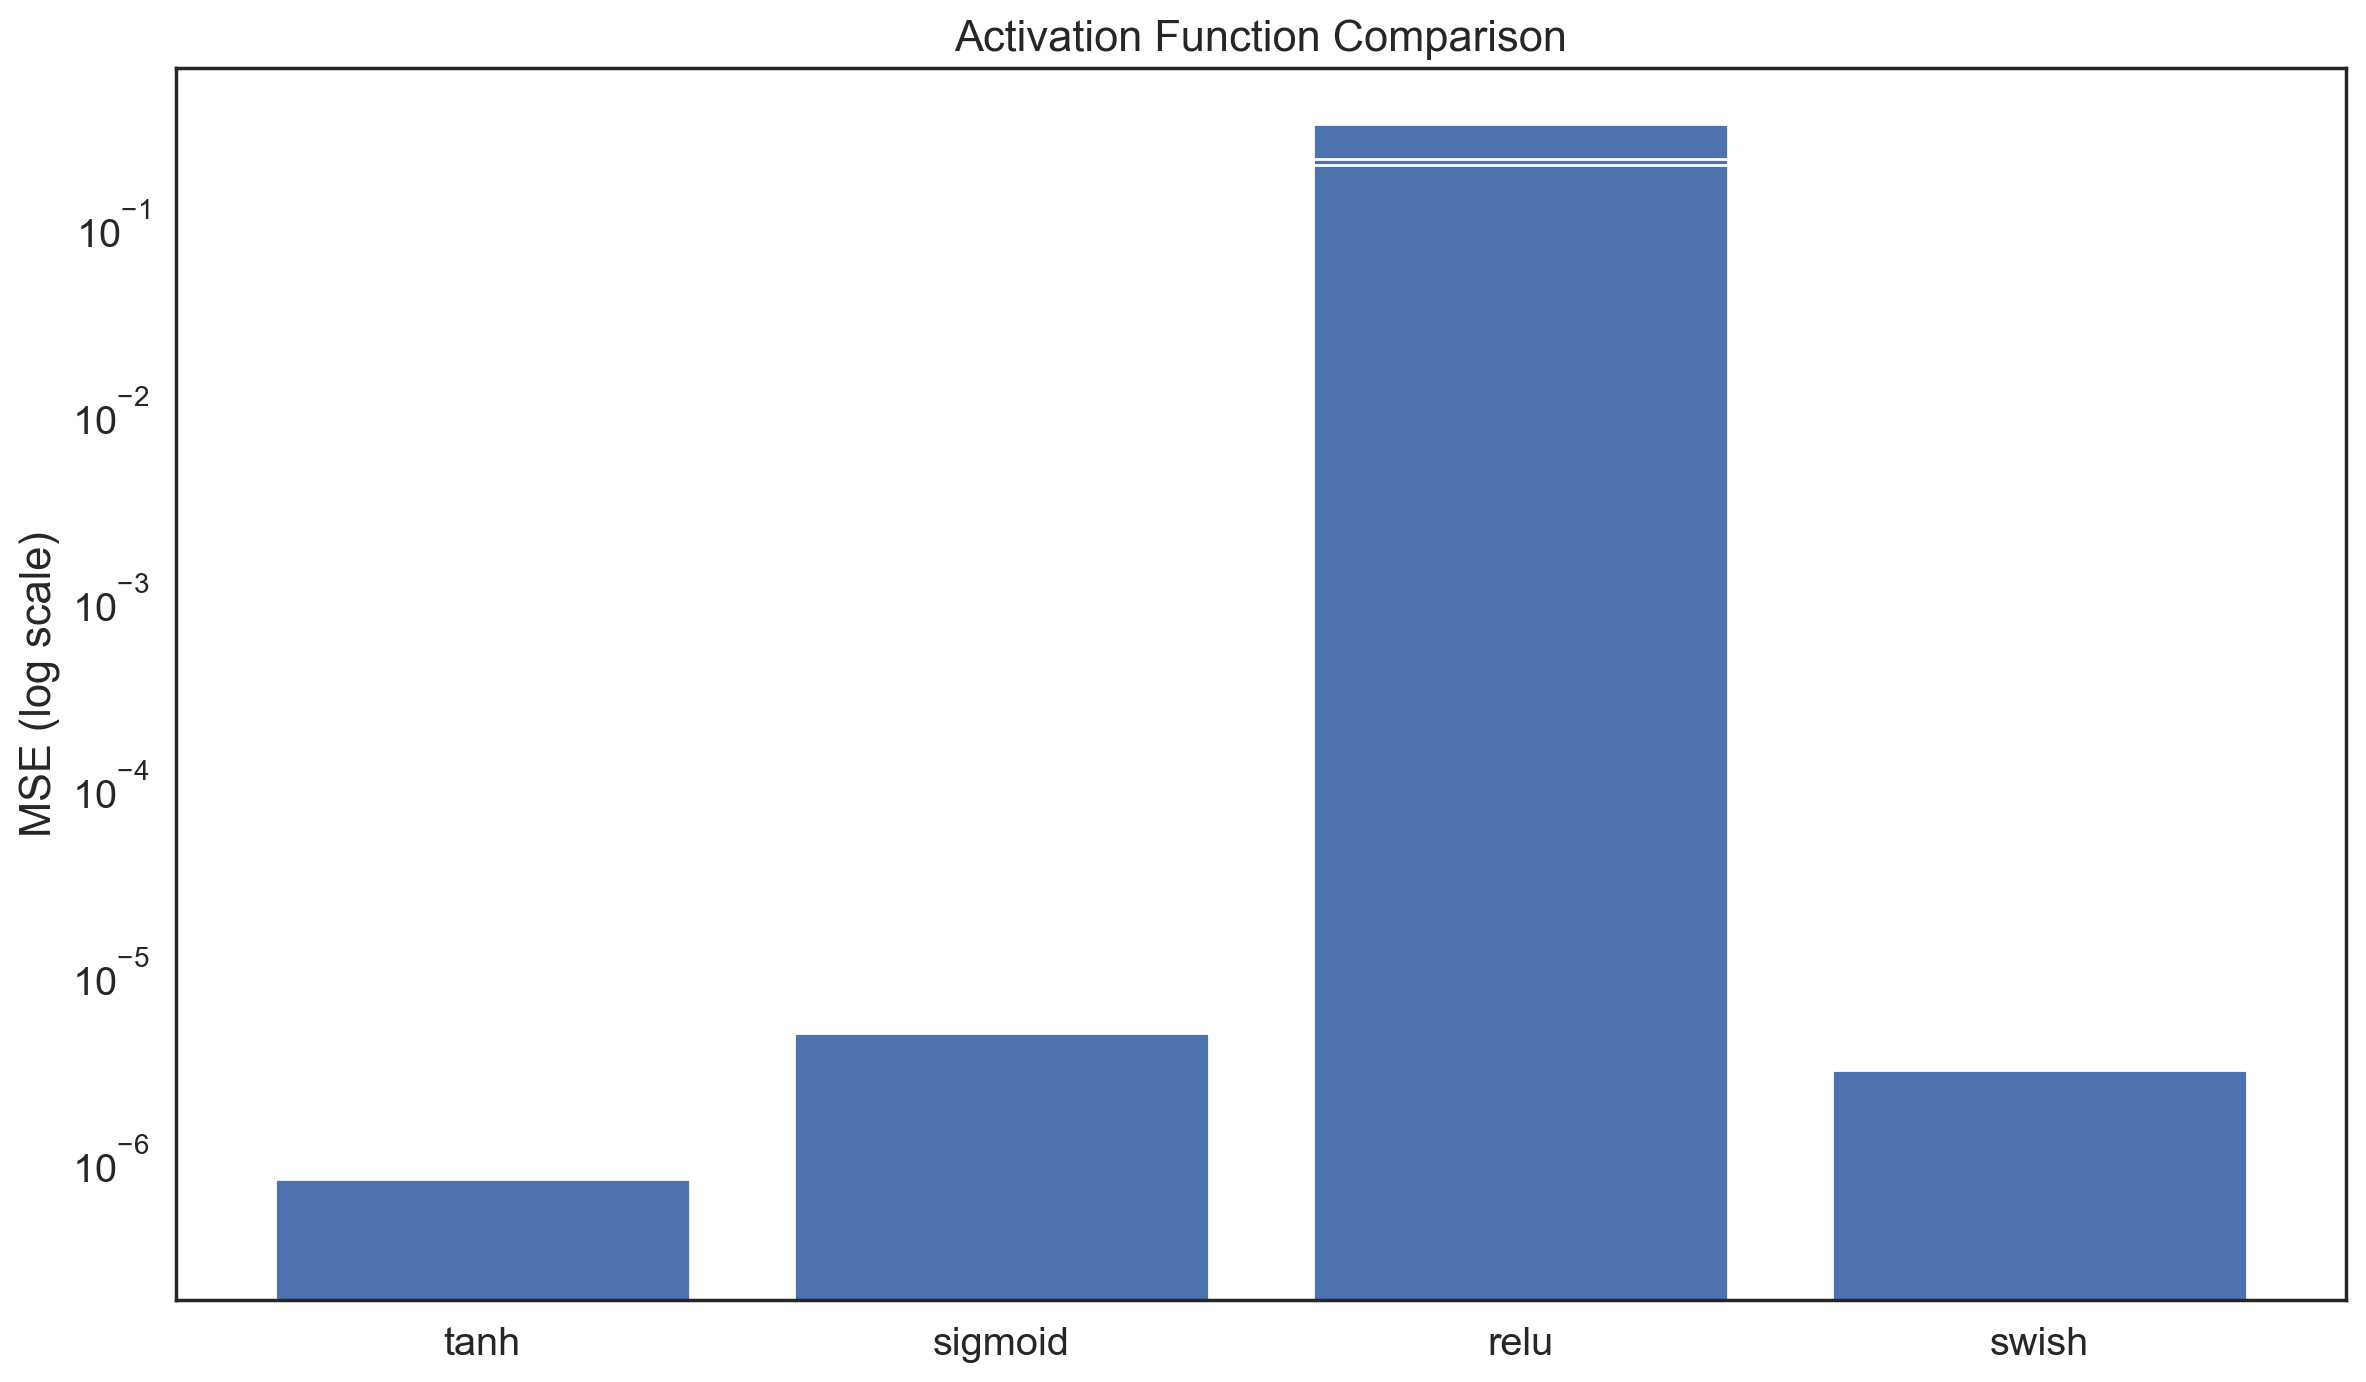

In [32]:
plt.bar(df_act['Activation'], df_act['MSE'])
plt.yscale('log')
plt.title("Activation Function Comparison")
plt.ylabel("MSE (log scale)")
plt.show()


In [33]:
print(df_eta.columns)


Index(['Learning rate', 'Residual loss', 'MSE'], dtype='object')


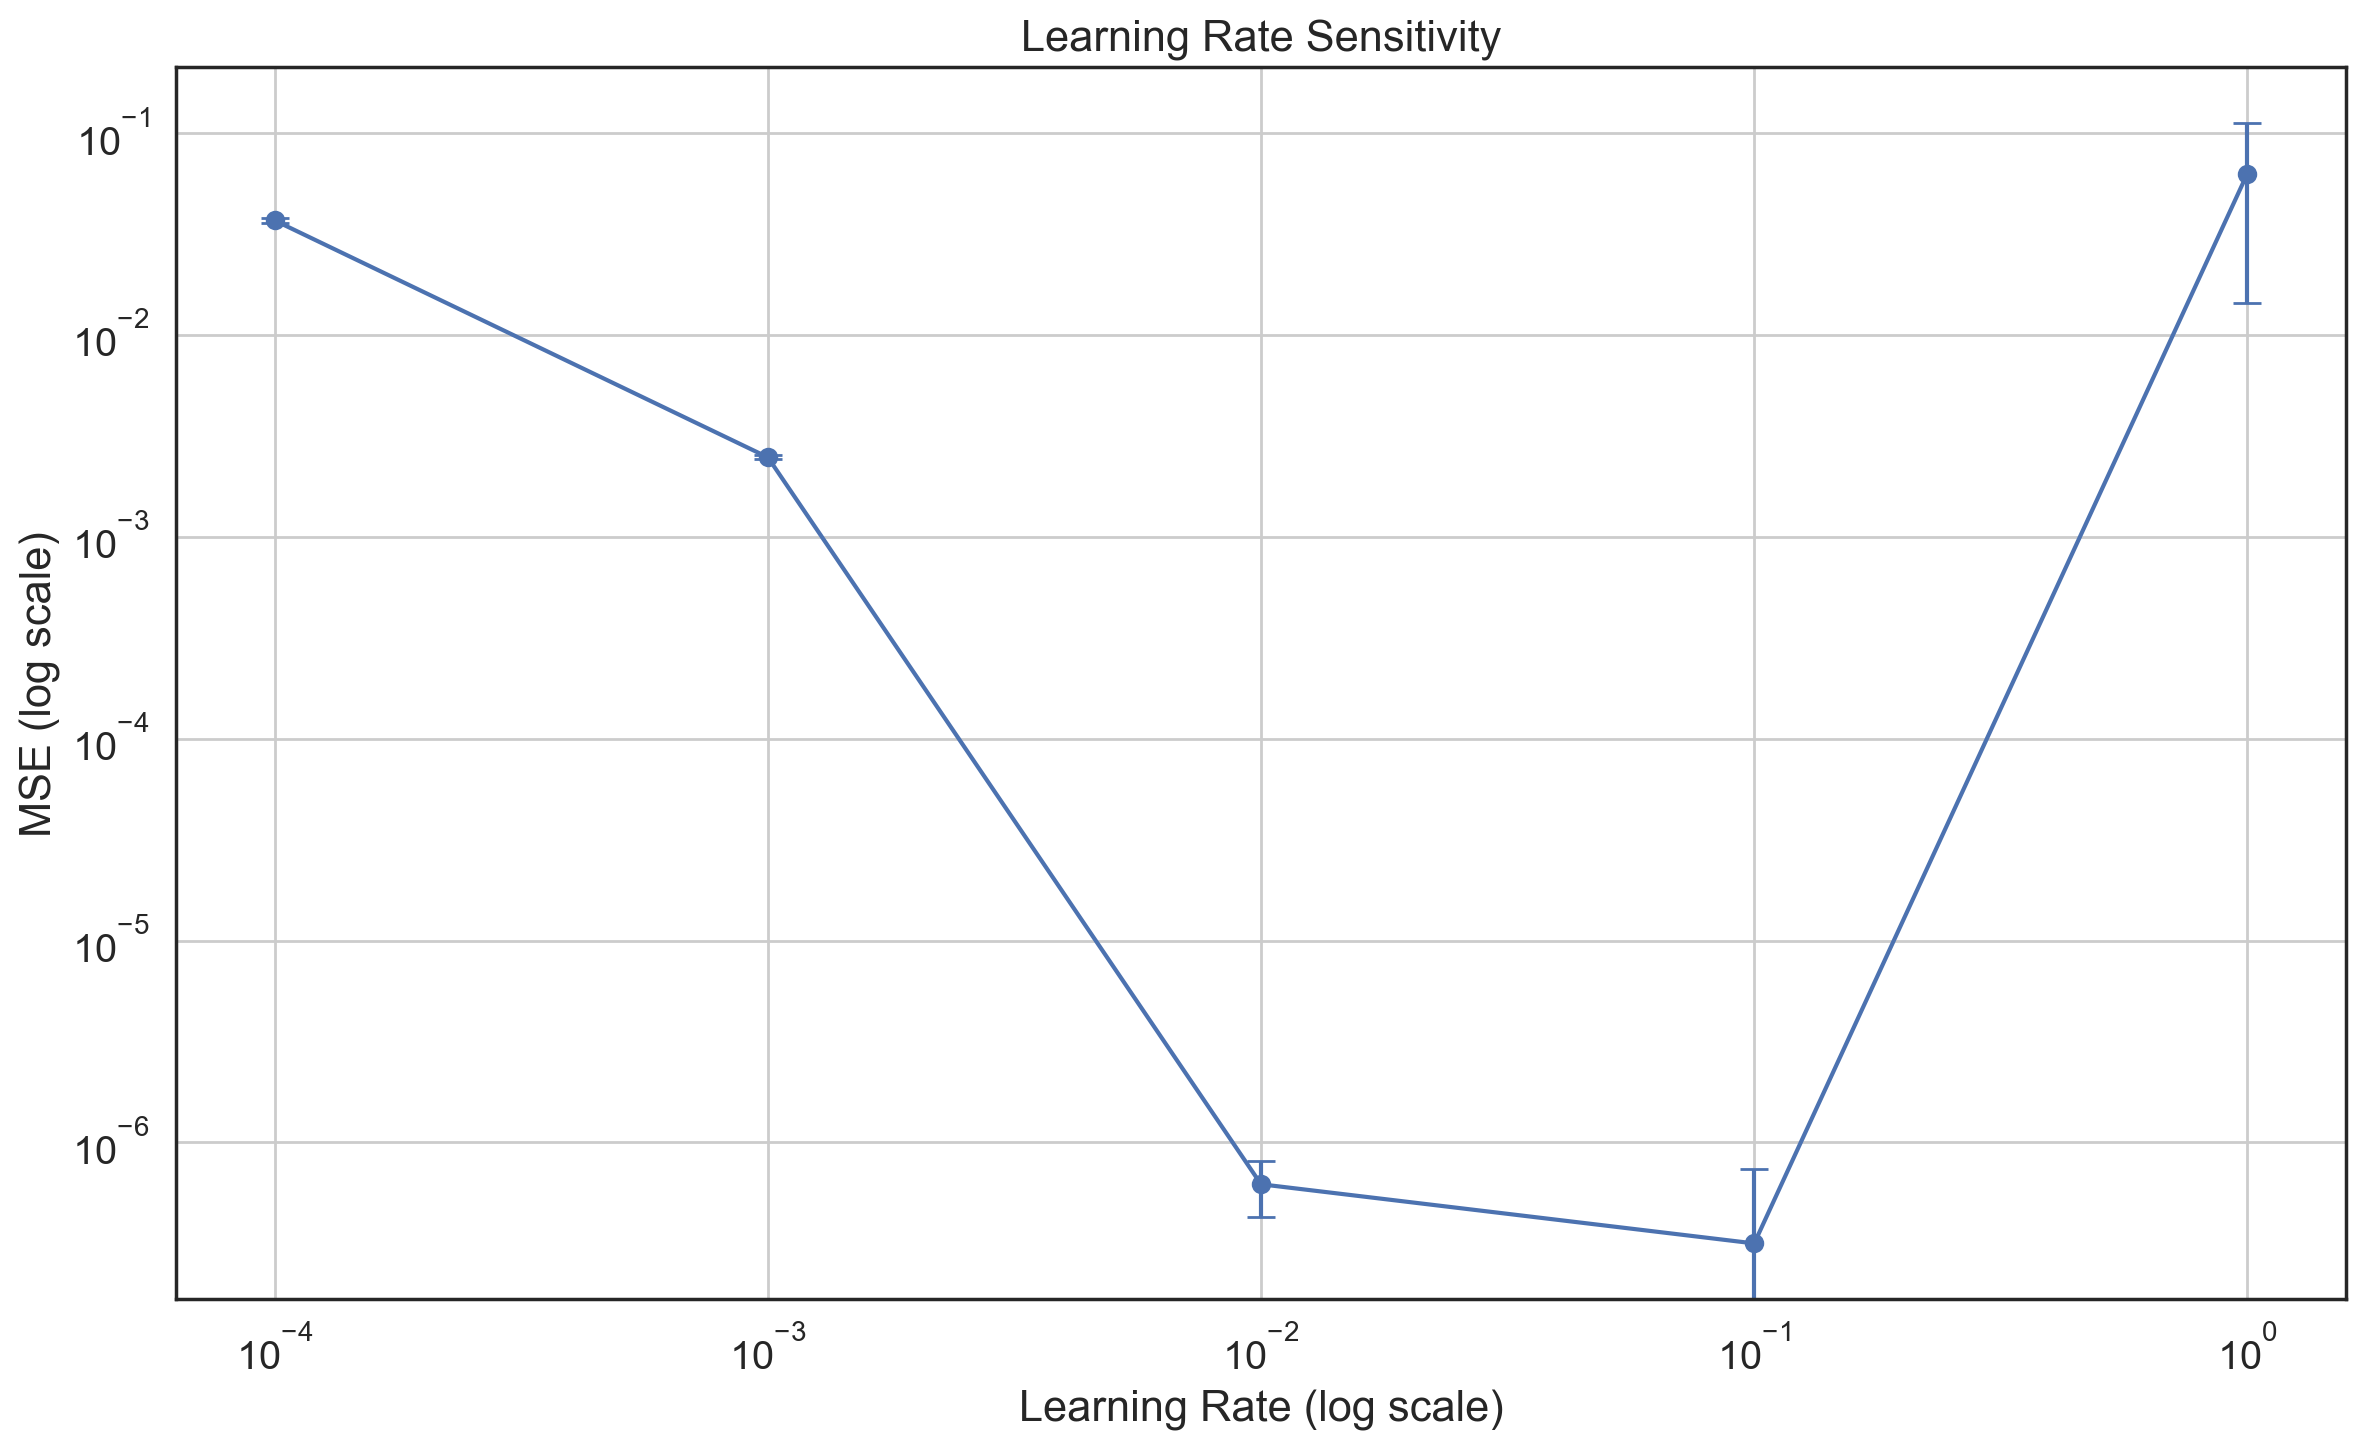

In [34]:
plt.errorbar(df_eta_summary["Learning rate"], df_eta_summary["mean_mse"],
             yerr=df_eta_summary["std_mse"], fmt='o-', capsize=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Learning Rate Sensitivity")
plt.grid(True)
plt.show()



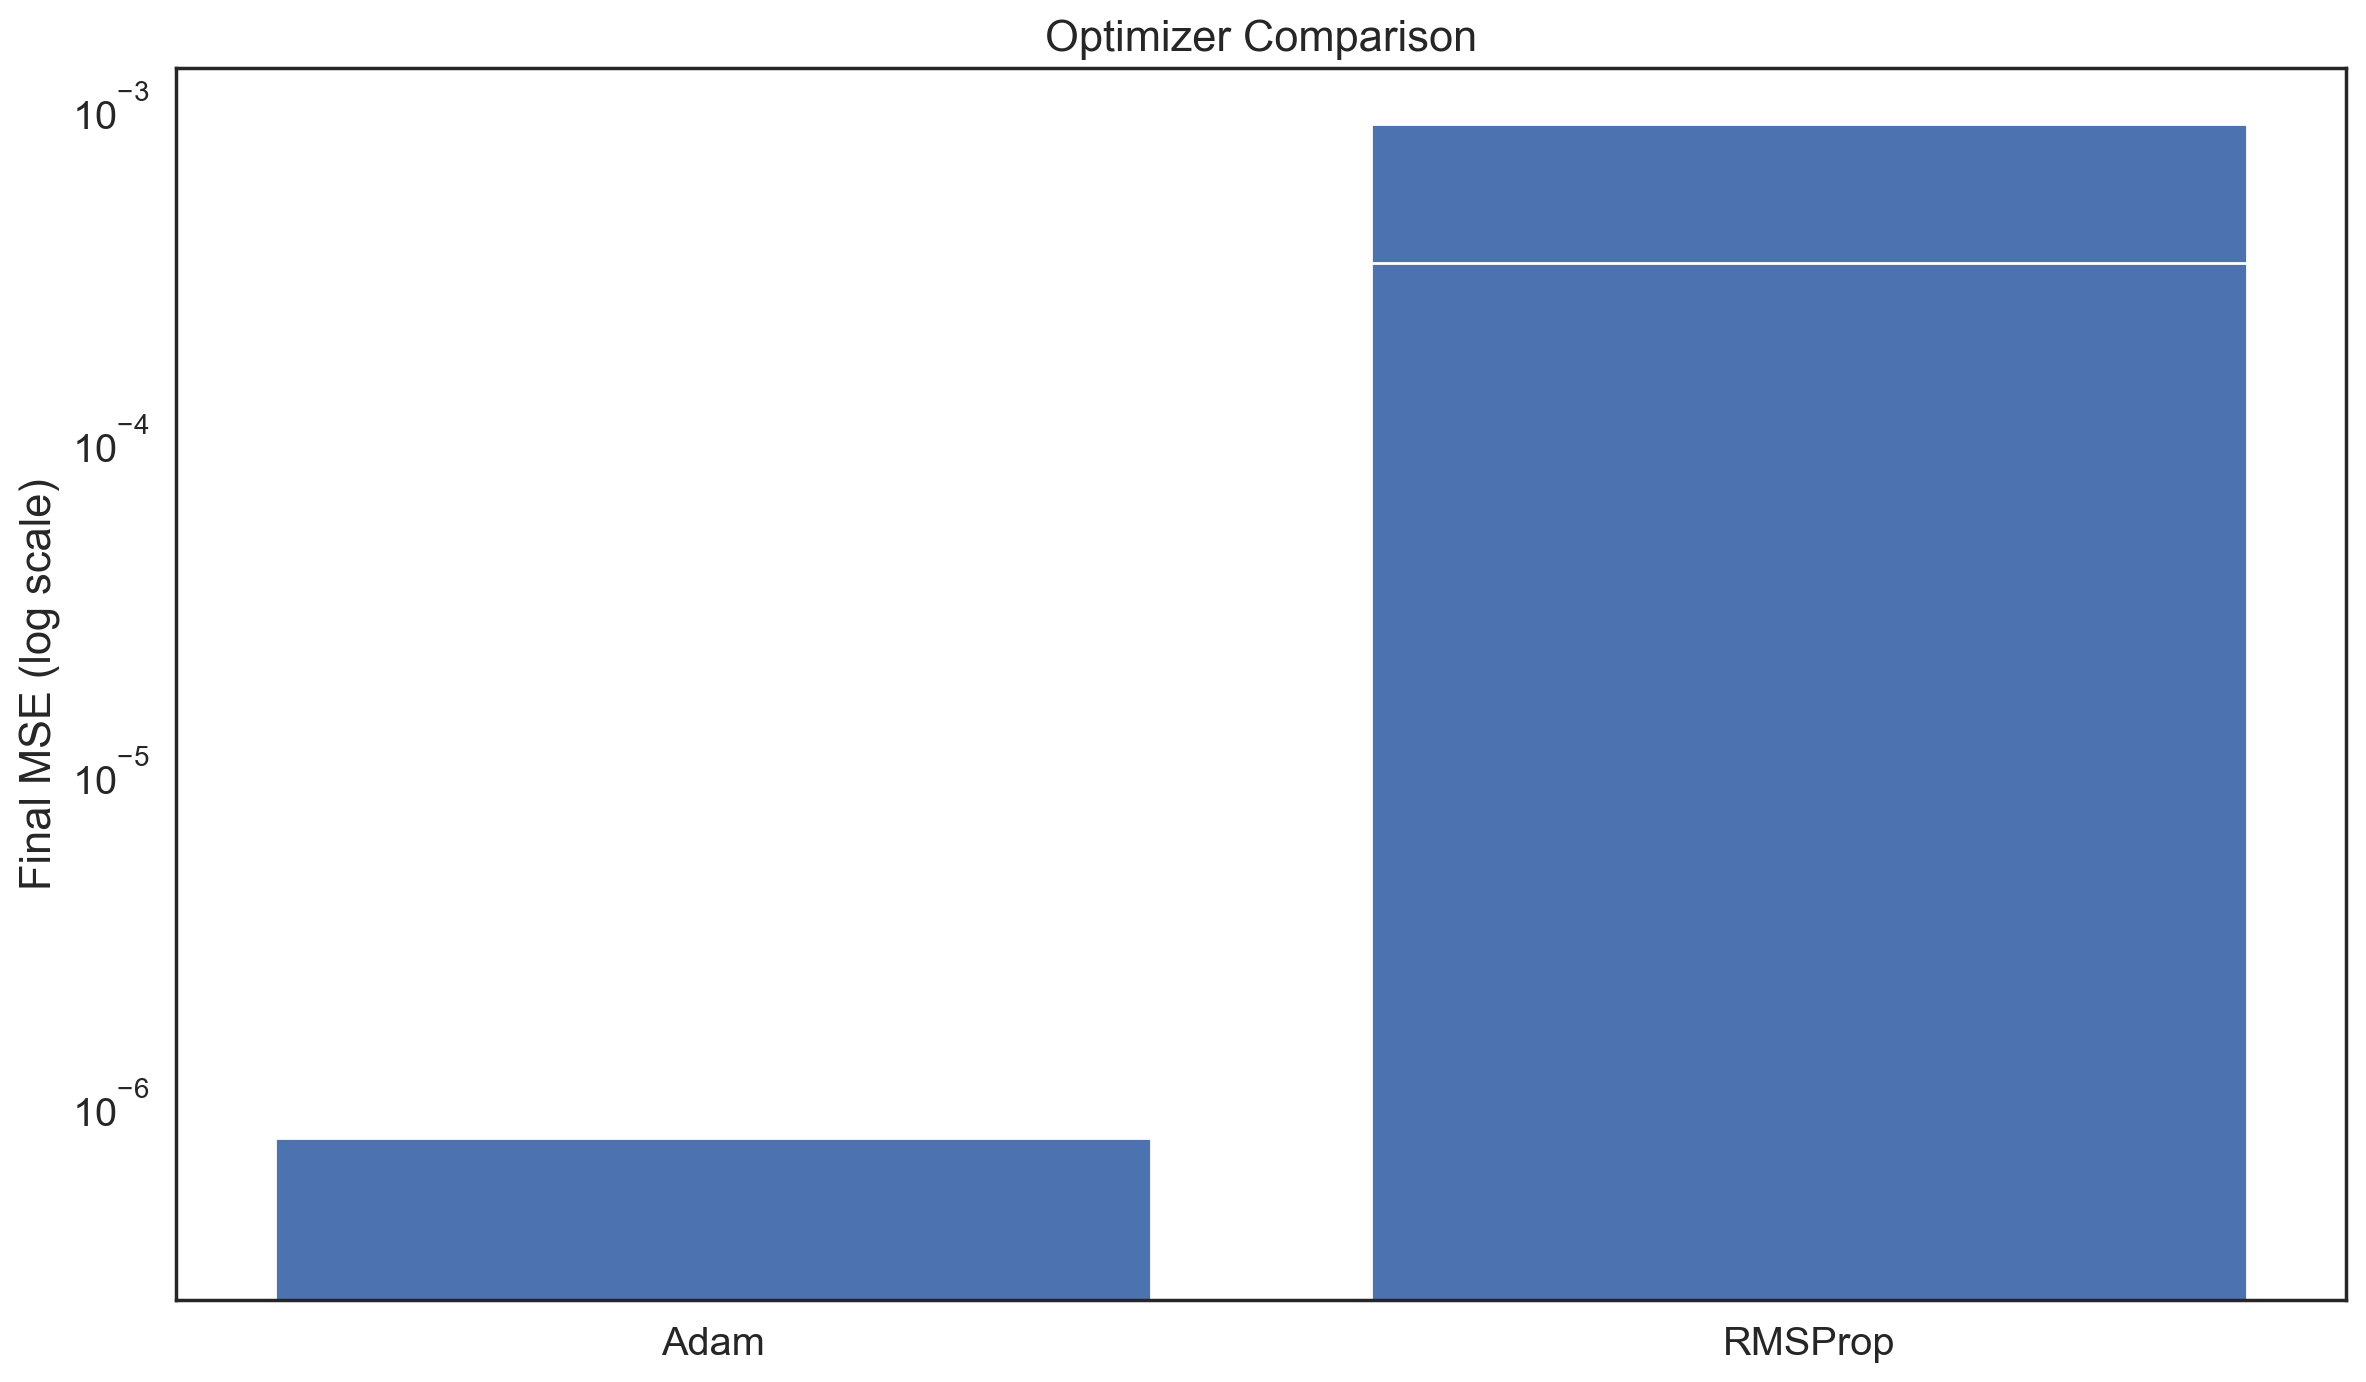

In [35]:
plt.bar(df_optim['Optimizer'], df_optim['MSE'])
plt.yscale('log')
plt.title("Optimizer Comparison")
plt.ylabel("Final MSE (log scale)")
plt.show()


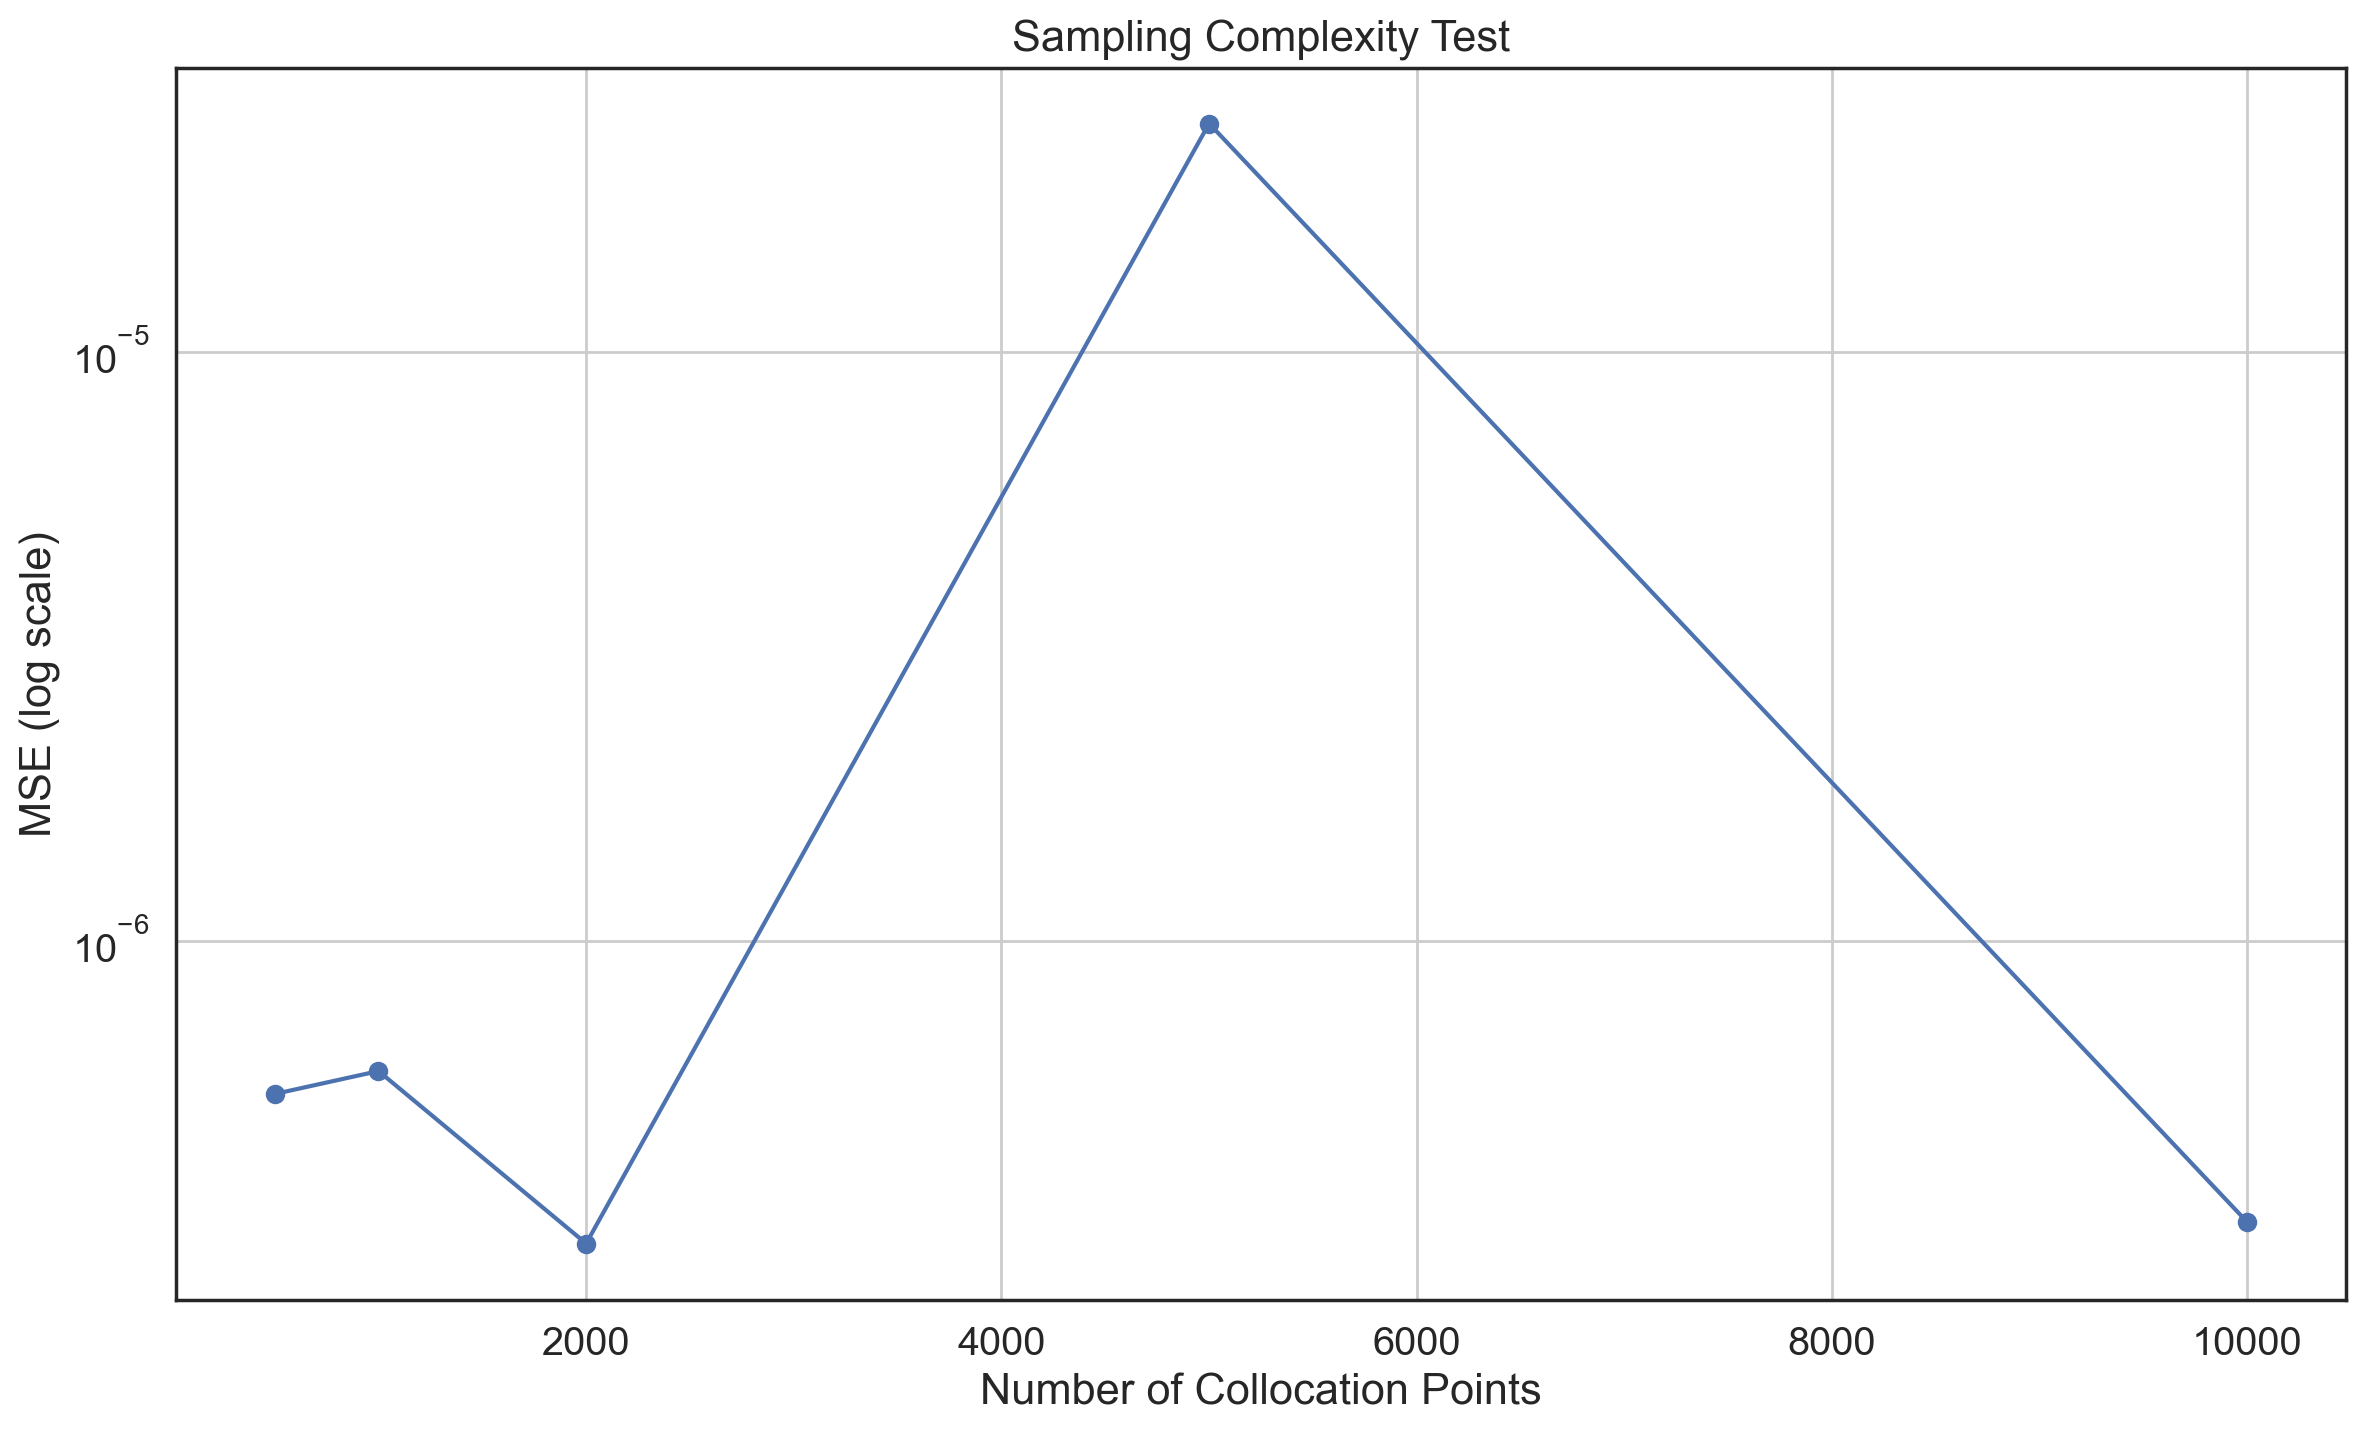

In [36]:
plt.plot(df_npoints['N_points'], df_npoints['MSE'], 'o-')
plt.yscale('log')
plt.xlabel("Number of Collocation Points")
plt.ylabel("MSE (log scale)")
plt.title("Sampling Complexity Test")
plt.grid(True)
plt.show()
